In [1]:
#import VANETFunctions.py as fn
# Importing necessary libraries
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from collections import Counter


In [2]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report


In [3]:
# Importing performance metrics
from sklearn import preprocessing,metrics

from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score)
from sklearn.model_selection import train_test_split 
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV)





In [4]:
# Hyperparameter Tuning
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV)



In [5]:
# Importing performance metrics
from sklearn import preprocessing,metrics
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score)
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve, plot_confusion_matrix


In [7]:

def save_model(model, filename):
    import pickle
    from os import path
    pkl_filename = "Dataset/savedFiles" + "/" + filename + ".pkl"
    if (not path.isfile(pkl_filename)):
  # saving the trained model to disk 
      with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)
      print("Saved model to disk")
    else:
      print("Previous Model exists on the disk! Please Remove")




In [8]:

data = pd.read_csv('/content/dataset_small.csv')
df = data.copy()


In [9]:
# Checking the balance of dataset
from collections import Counter
Counter(df['phishing']) # Data is nearly balanced
phishingClassRatio = df[df['phishing'] == 1].shape[0]/df.shape[0]*100
print("Percentage of phishing data in dataset: ", round(phishingClassRatio,2))


Percentage of phishing data in dataset:  52.26


In [10]:
df.columns


Index(['qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url',
       'qty_questionmark_url', 'qty_equal_url', 'qty_at_url', 'qty_and_url',
       'qty_exclamation_url', 'qty_space_url',
       ...
       'qty_ip_resolved', 'qty_nameservers', 'qty_mx_servers', 'ttl_hostname',
       'tls_ssl_certificate', 'qty_redirects', 'url_google_index',
       'domain_google_index', 'url_shortened', 'phishing'],
      dtype='object', length=112)

In [11]:
df.isnull().sum() # There are no missing values present in dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 50.1 MB


In [12]:
# Finding number of levels in each variable
unique = df.nunique().sort_values(ascending = False)
# The variables which has only one unique value have same fixed value for all samples so such variables cannot be considered as variable 


In [13]:

# Removing variables which has same value for all samples
# Extracting variable names with only 1 uniques level
noVar = unique[unique == 1].index

df.drop(columns = noVar, axis = 1, inplace = True)



In [14]:
# Removed duplicates
df.drop_duplicates(keep = 'first', inplace = True)


summary = df.describe().T



In [15]:
# Not removing outliers from those variables which has 0 IQR because that will cause to delete all samples from variable
var0Iqr = summary.loc[(summary['25%']==0) & (summary['50%'] == 0) & (summary['75%'] == 0)].index.tolist()
setVar0Iqr = set(var0Iqr)


In [16]:

# Function for replacing outliers with IQR method
def fun_iqr(var):
    # Calculating 25th and 75th quartile
    q25, q75 = var.quantile(0.25), var.quantile(0.75)

    # calculating interquartile range
    iqr = q75-q25

    # Calculating upper and lower whiskers of boxplot
    lower, upper = q25 - 1.5*iqr, q75 + 1.5*iqr
    return lower, upper



In [17]:

def outliers(df,list):
    for i in range(len(list)):
        # IQR method for replacing outliers
        lower, upper = fun_iqr(df[list[i]])
        
        # Replacing the outliers with median( Median is considered because it is not affected by outliers) to prevent the loss of data
        #df[list[i]] = np.where((df[list[i]] < lower) | (df[list[i]] > upper), df[list[i]].median(), df[list[i]])
        outliers = df[((df[list[i]]<lower) | (df[list[i]]>upper))]
        return outliers
        #return df_no_out
        #sns.boxplot(y=df[list[i]])
        #plt.show()



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


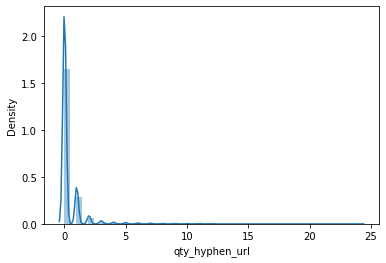

In [18]:

# Removing column names which has 0 Iqr
ls = df.columns
setAllVar = set(ls)
set = setAllVar.difference(setVar0Iqr)
ls = list(set)


df_out = outliers(df, ls)
index = df_out.index.tolist()
dfOutDrop = df.drop(index, axis = 0)
dfCleaned = dfOutDrop.reset_index()
dfCleaned.drop(columns = ['index'], axis = 1, inplace = True)

summ = dfCleaned.describe()

sns.distplot(dfCleaned['qty_hyphen_url'])
plt.show()



In [19]:

# Creating train test data (retaining original dataframe in df)
y = dfCleaned['phishing']
X = dfCleaned.drop(columns = ['phishing'], axis = 1)

# Standardization
col = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = col)


#----------------------------------------PCA: 97% explained variance-----------------------------------------
pca = PCA(n_components = 0.97)
pcaProjection = pca.fit_transform(X)
explainedVariance = pca.explained_variance_ratio_
var = np.round(pca.explained_variance_ratio_, decimals=3)*100



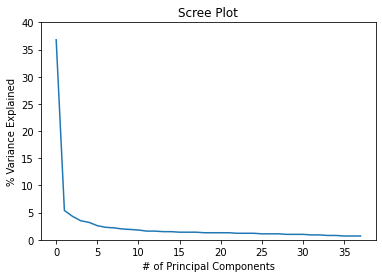

In [20]:

# Plot showing the amount of cumulative variation explained with corresponding number of components 
plt.ylabel('% Variance Explained')
plt.xlabel('# of Principal Components')
plt.title('Scree Plot')
plt.ylim(0,40)
plt.style.context('seaborn-whitegrid')
plt.plot(var)
plt.show()
# From scree plot we can select 10 components near elbow. After that explained variance is similar for further components.



In [21]:

# Percentage of cumulative variance 
varCum=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
varCum



array([36.8, 42.2, 46.5, 50. , 53.2, 55.8, 58.1, 60.3, 62.3, 64.2, 66. ,
       67.6, 69.2, 70.7, 72.2, 73.6, 75. , 76.4, 77.7, 79. , 80.3, 81.6,
       82.8, 84. , 85.2, 86.3, 87.4, 88.5, 89.5, 90.5, 91.5, 92.4, 93.3,
       94.1, 94.9, 95.6, 96.3, 97. ])

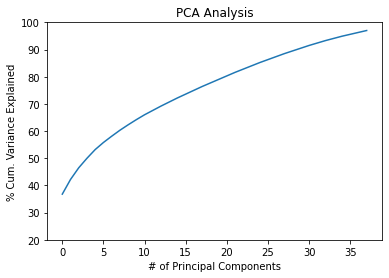

In [22]:

# Plot showing the amount of cumulative variation explained with corresponding number of components 
plt.ylabel('% Cum. Variance Explained')
plt.xlabel('# of Principal Components')
plt.title('PCA Analysis')
plt.ylim(20,100)
plt.style.context('seaborn-whitegrid')
plt.plot(varCum)
plt.show()


In [ ]:

# Adding PC names to columns
# Extracting PC components. Added 1 to start with 1 till 43
PC_values = np.arange(pca.n_components_) + 1
PCs = pd.DataFrame(PC_values)
# Adding string 'PC' to each value of column
PCs[0] = 'PC' + PCs[0].astype(str)
type(PCs[0])
# Converting series to list to obtain a list of column names
PClist = PCs[0].tolist()

# Assigning column names to dataframe
X_pca = pd.DataFrame(pcaProjection, columns = PClist)


# Selecting 10 principal components  
X = X_pca.iloc[:,:10]
y = pd.DataFrame(y, columns = ['phishing'])
df = pd.concat([X, y], axis = 1)


sns.pairplot(df, hue = 'phishing', palette= 'hls')
plt.show()

y = df['phishing']
X = df.drop(columns = ['phishing'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 0)



In [ ]:
#_________________________________________________________________________________________________________________

# Functions:
    
def evaluate_classification_model(y_test, y_pred_test):
    
    target_names = ['Non-phished', 'Phishing']

    print(classification_report(y_test, y_pred_test, target_names=target_names))


    conf_matrix = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(data=conf_matrix, annot=True, fmt='g', xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xtickslabels(rotation=90)
    plt.ytickslabels(rotation=90)
    plt.yticks(target_names)
    plt.show()



In [ ]:

## Define function
def fit_n_pred(model, X_tr, y_tr, X_te):
    
    """Takes in Classifier, training data (X,y), and test data(X). Will output 
    predictions based upon both the training and test data using the sklearn
    .predict method. MUST unpack into two variables (train, test)."""
    
    ## Fitting classifier to training data
    model.fit(X_tr, y_tr)

    ## Generate predictions for training + test data
    y_preds = model.predict(X_te)
    y_preds_prob = model.predict_proba(X_te)[:,1]
    
    ## Optional display check
    #display(model)
    #print(model.best_params_)
    
    return y_preds, y_preds_prob



In [ ]:

#plot_curve(y_test, y_preds_prob, 'Random Forest with Important Features')
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = metrics.roc_curve(truth,pred)       # Returns fpr, tpr and thresholds
    roc_auc = metrics.auc(fpr, tpr)                            # Returns area under the curve 
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right", fontsize=10)
    
    



In [ ]:

#--------------------------------------XGB Classifier with 10 PCs-------------------------------------------


params = {
"xgbclassifier__learning_rate" : [0.05, 0.1, 0.20],
#"subsample" : [0.6, 0.8, 1.0],
"xgbclassifier__max_depth" : [3,4,5, 6, 8, 10],
"xgbclassifier__min_child_weight" : [1,3,5],
"xgbclassifier__gamma" : [0.0, 0.5, 1.0, 1.5]
    }

imba_pipeline = make_pipeline(XGBClassifier(random_state=13))

rs_xg = RandomizedSearchCV(imba_pipeline, params, scoring = 'accuracy')

y_pred, y_pred_prob = fit_n_pred(rs_xg, X_train, y_train, X_test)
rs_xg.best_params_

evaluate_classification_model(y_test, y_pred)
plotAUC(y_test, y_pred_prob, 'XG Boost')


#______________________________________________________________________________________________________


In [ ]:

#--------------------------------XGB classifier with 43 PCs and 97% variance------------------------------

y = pd.DataFrame(y, columns = ['phishing'])
df_new = pd.concat([X_pca, y], axis = 1)

y = df_new['phishing']
X = df_new.drop(columns = ['phishing'], axis = 1)
Counter(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 0)

#--------------------------------------XGB Classifier-------------------------------------------

params = {
"xgbclassifier__learning_rate" : [0.05, 0.1, 0.20],
#"subsample" : [0.6, 0.8, 1.0],
"xgbclassifier__max_depth" : [3,4,5, 6, 8, 10],
"xgbclassifier__min_child_weight" : [1,3,5],
"xgbclassifier__gamma" : [0.0, 0.5, 1.0, 1.5]
    }

imba_pipeline = make_pipeline(SMOTE(random_state=42), XGBClassifier(random_state=13))

rs_xg = RandomizedSearchCV(imba_pipeline, params, scoring = 'accuracy')

y_pred, y_pred_prob = fit_n_pred(rs_xg, X_train, y_train, X_test)
rs_xg.best_params_

evaluate_classification_model(y_test, y_pred)
plotAUC(y_test, y_pred_prob, 'XG Boost')
save_model(rs_xg, 'modelPcaXgb')

#_____________________________________________________________________________________________________



In [ ]:

#------------------------------------Random Forest Model (n = 10)------------------------------------------

# Selecting 10 principal components  
X = X_pca.iloc[:,:10]
y = pd.DataFrame(y, columns = ['phishing'])
df = pd.concat([X, y], axis = 1)


y = df['phishing']
X = df.drop(columns = ['phishing'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 0)



params = {'n_estimators': [50, 100, 200],
 'max_depth': [4, 6, 10, 12],
 'random_state': [13]}


imba_pipeline = make_pipeline(SMOTE(random_state=42), StandardScaler(), RandomForestClassifier(random_state=13))
new_params = {'randomforestclassifier__' + key: params[key] for key in params} # Passing the parameters

# By default cv=5
rs_rf = RandomizedSearchCV(imba_pipeline, new_params, cv=5, scoring='accuracy', return_train_score=True)
rs_rf.fit(X_train, y_train)

rs_rf.best_params_

y_preds = rs_rf.predict(X_test)
y_preds_prob = rs_rf.predict_proba(X_test)[:,1]
#y_pred, y_pred_prob = fit_n_pred(rs_rf, X_train, y_train, X_test)

evaluate_classification_model(y_test, y_pred)
plotAUC(y_test, y_pred_prob, 'XG Boost')
save_model(rs_rf, 'modelPcaRf')

#________________________________________________________________________________________________________
#-------------------------------------------------END-----------------------------------------------------------


In [ ]:

#---------------------------------Logistic Regression: Trial---------------------------------------

from sklearn.linear_model import LogisticRegression
pipelineLR = make_pipeline(SMOTE(random_state=42), StandardScaler(), LogisticRegression(random_state=1, penalty='l2', solver='lbfgs'))

# Create the parameter grid

param_grid_lr = [{
    'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0]
}]

# Create an instance of GridSearch Cross-validation estimator

gsLR = GridSearchCV(estimator=pipelineLR,
                     param_grid = param_grid_lr,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)

# Train the LogisticRegression Classifier
gsLR = gsLR.fit(X_train_over_sampled, Y_train_over_sampled)

# Print the training score of the best model
print(gsLR.best_score_)

# Print the model parameters of the best model
print(gsLR.best_params_) # {'logisticregression__C': 0.001}

# Print the test score of the best model
clfLR = gsLR.best_estimator_








